# Imports

In [163]:
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from IPython.display import Image
from xgboost import XGBRegressor
import re

In [164]:
data = pd.read_csv("housePrice.csv")
data.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


# Exploratory data analysis (EDA) 

In [165]:
data.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [166]:
data.shape

(3479, 8)

In [167]:
data.isnull().sum() / data.shape[0] 

Area          0.000000
Room          0.000000
Parking       0.000000
Warehouse     0.000000
Elevator      0.000000
Address       0.006611
Price         0.000000
Price(USD)    0.000000
dtype: float64

In [168]:
data.dtypes

Area           object
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
dtype: object

In [169]:
len(data["Address"].unique())

193

In [170]:
print("highest price in each district :",data.groupby("Address")["Price"].max())
print("\n lowest price in each district : ",data.groupby("Address")["Price"].min())

highest price in each district : Address
Abazar         9.100000e+10
Abbasabad      4.000000e+09
Absard         5.200000e+09
Abuzar         2.715000e+09
Afsarieh       3.150000e+09
                   ...     
Yousef Abad    1.800000e+10
Zafar          8.000000e+10
Zaferanieh     9.240000e+10
Zargandeh      9.000000e+09
Zibadasht      4.350000e+09
Name: Price, Length: 192, dtype: float64

 lowest price in each district :  Address
Abazar         2.500000e+09
Abbasabad      2.460000e+09
Absard         3.100000e+09
Abuzar         8.500000e+08
Afsarieh       1.120000e+09
                   ...     
Yousef Abad    2.150000e+09
Zafar          1.200000e+09
Zaferanieh     6.700000e+09
Zargandeh      5.600000e+09
Zibadasht      4.350000e+09
Name: Price, Length: 192, dtype: float64


# Pre-proccessing

 Area --> int
<br> Price --> DELETE
<br> Parking | Warehouse | Elevator --> One_Hot encode
<br> Address --> label-encode | target-encode

In [171]:
data = data.dropna()
cols_bool = ['Parking', 'Warehouse', 'Elevator']
data[cols_bool] = data[cols_bool].astype(int)

In [172]:
data[data['Area'].str.replace(',', '').str.isnumeric() == False]['Area']
data = data.dropna(subset=['Area'])


In [173]:
import re

def clean_area(x):
    if pd.isna(x):
        return None
    x = str(x)
    x = x.replace(',', '')      # remove commas
    x = re.sub(r'\D', '', x)    # keep only digits
    return int(x) if x.isdigit() else None

data['Area'] = data['Area'].apply(clean_area)


data['Area'] = data['Area'].astype(int)

In [174]:
data['Area'].describe()

count    3.456000e+03
mean     8.802191e+06
std      3.177783e+08
min      3.000000e+01
25%      6.900000e+01
50%      9.000000e+01
75%      1.210000e+02
max      1.616000e+10
Name: Area, dtype: float64

### Area outlier handled logically

In [175]:
data = data[(data['Area'] >= 20) & (data['Area'] <= 2000)]


In [176]:
le = LabelEncoder()
data["Address"] = le.fit_transform(data["Address"])

In [177]:
g = data.groupby("Address")["Price"]

data["addr_price_mean"] = data["Address"].map(g.mean())
data["addr_price_min"]  = data["Address"].map(g.min())
data["addr_price_max"]  = data["Address"].map(g.max())


# Visualisation

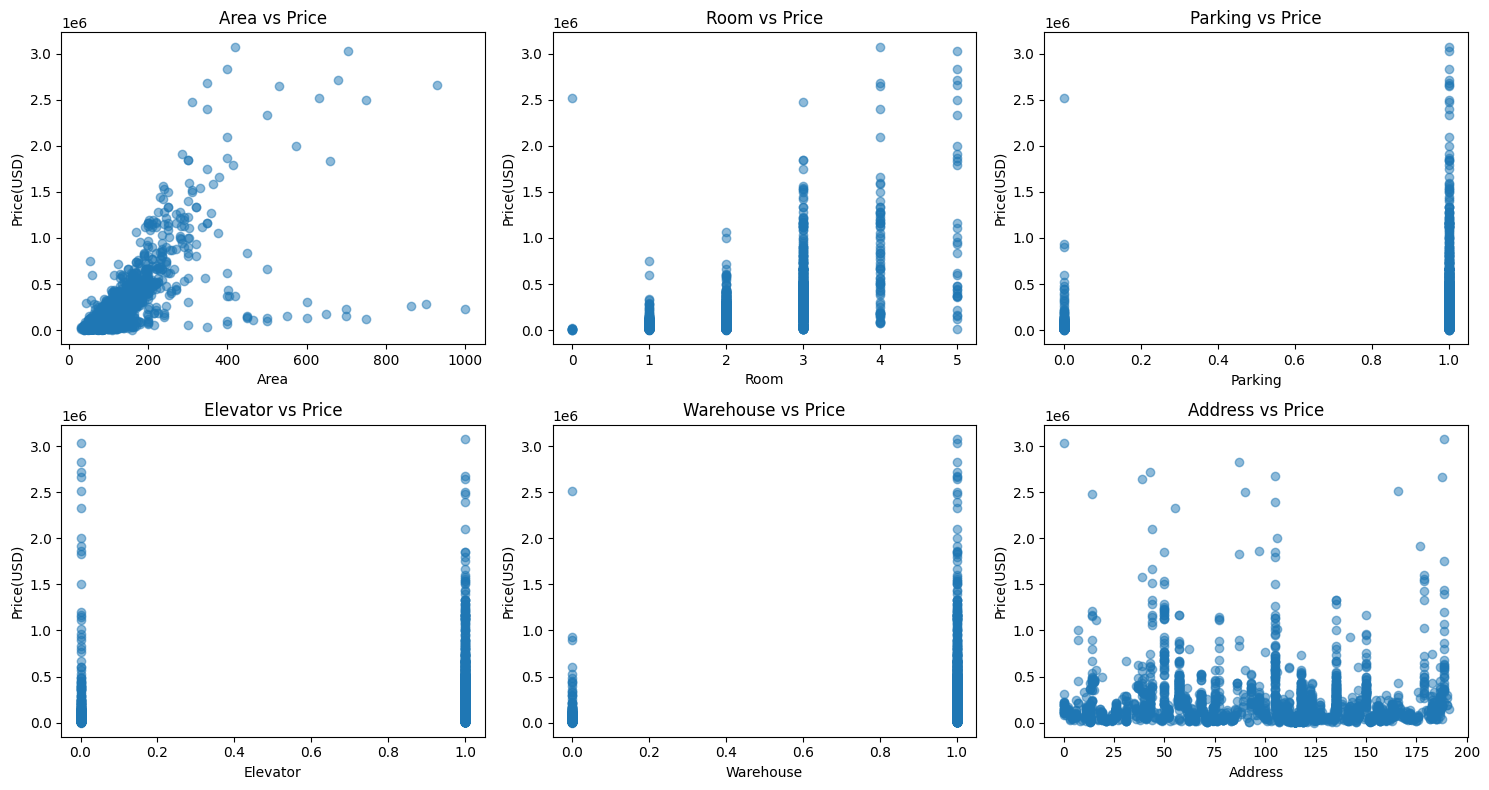

In [178]:
features = ['Area', 'Room', 'Parking', 'Elevator', 'Warehouse', 'Address']  

n = len(features)
cols = 3  
rows = (n + cols - 1) // cols  

plt.figure(figsize=(cols * 5, rows * 4)) 

for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    plt.scatter(data[feature], data['Price(USD)'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Price(USD)')
    plt.title(f'{feature} vs Price')

plt.tight_layout()
plt.show()

In [179]:
data['Price(USD)'].describe()

count    3.451000e+03
mean     1.792011e+05
std      2.708262e+05
min      1.200000e+02
25%      4.731667e+04
50%      9.666667e+04
75%      2.000000e+05
max      3.080000e+06
Name: Price(USD), dtype: float64

In [ ]:

# plt.figure(figsize=(12, 5))
# plt.boxplot(data['Price(USD)'], vert=False)
# plt.xlabel("Price(USD)")
# plt.title("Box Plot of Area")
# plt.show()


# more intractive plot

import plotly.express as ex

ex.box(x="Price(USD)",data_frame=data)

In [181]:
ex.box(x="Area",data_frame=data)

### Handling outlier

In [182]:



Q1 = data['Price(USD)'].quantile(0.25)
Q3 = data['Price(USD)'].quantile(0.75)
IQR = Q3 - Q1

outliers = (data['Price(USD)'] < (Q1 - 1.5 * IQR)) | (data['Price(USD)'] > (Q3 + 1.5 * IQR))
print(outliers.sum())


309


In [183]:
data = data[~outliers]

### ["Area"] doesnt need deleting outlier

In [184]:
Q1 = data['Area'].quantile(0.25)
Q3 = data['Area'].quantile(0.75)
IQR = Q3 - Q1

outliers = (data['Area'] < (Q1 - 1.5 * IQR)) | (data['Area'] > (Q3 + 1.5 * IQR))
print(outliers.sum())

85


Text(0.5, 1.0, 'Correlation')

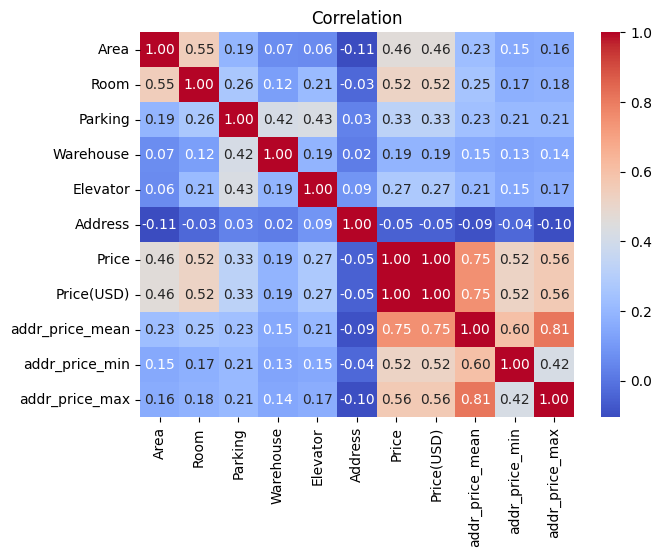

In [185]:
corr = data.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr,annot=True,fmt='.2f',cmap="coolwarm")
plt.title("Correlation")

# splitting data

In [186]:
X = data[['Area', 'Room', 'Parking', 'Elevator', 'Warehouse', 'Address',"addr_price_mean"	,"addr_price_min"	,"addr_price_max"]]
y = data['Price(USD)']

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [188]:
# 1️⃣ Create the scaler
scaler = StandardScaler()

# 2️⃣ Fit only on the training set, then transform both
train_scaled = scaler.fit_transform(X_train)

test_scaled = scaler.transform(X_test) # our test is x_test

# best model and parameter

In [189]:
import optuna
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


def objective(trial):
    model_name = trial.suggest_categorical("model", ["svr", "linear", "dt", "xgb"])

    if model_name == "svr":
        model = SVR(
            C=trial.suggest_float("C", 0.1, 100.0, log=True),
            epsilon=trial.suggest_float("epsilon", 0.01, 1.0),
            kernel="rbf",
        )

    elif model_name == "linear":
        model = LinearRegression()

    elif model_name == "dt":
        model = DecisionTreeRegressor(
            max_depth=trial.suggest_int("max_depth", 2, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
            random_state=42,
        )

    else:  # xgb
        model = XGBRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 800),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            max_depth=trial.suggest_int("max_depth", 3, 12),
            objective="reg:squarederror",
            random_state=42,
        )

    # Train
    model.fit(train_scaled, y_train)

    # Predict
    y_pred_train = model.predict(train_scaled)
    y_pred_test = model.predict(test_scaled)

    # Scores
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # Save scores into trial metadata
    trial.set_user_attr("r2_train", r2_train)
    trial.set_user_attr("r2_test", r2_test)

    return r2_test   # optimize only test score


# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best trial reference
best_trial = study.best_trial

# Clean output
print("\n===== Best Result =====")
print(f"R² Train: {best_trial.user_attrs['r2_train']:.4f}")
print(f"R² Test : {best_trial.user_attrs['r2_test']:.4f}")

print("\n===== Best Parameters =====")
for k, v in best_trial.params.items():
    print(f"{k}: {v}")


[I 2025-11-16 19:28:56,217] A new study created in memory with name: no-name-17d8a581-e463-4ba0-a356-8aaaaba1c455
[I 2025-11-16 19:28:56,223] Trial 0 finished with value: 0.7224255726527399 and parameters: {'model': 'linear'}. Best is trial 0 with value: 0.7224255726527399.
[I 2025-11-16 19:28:57,556] Trial 1 finished with value: 0.8809628502825502 and parameters: {'model': 'xgb', 'n_estimators': 423, 'learning_rate': 0.011652931175731181, 'max_depth': 12}. Best is trial 1 with value: 0.8809628502825502.
[I 2025-11-16 19:28:57,560] Trial 2 finished with value: 0.7224255726527399 and parameters: {'model': 'linear'}. Best is trial 1 with value: 0.8809628502825502.
[I 2025-11-16 19:28:57,571] Trial 3 finished with value: 0.8674265753643609 and parameters: {'model': 'dt', 'max_depth': 20, 'min_samples_split': 10}. Best is trial 1 with value: 0.8809628502825502.
[I 2025-11-16 19:28:57,582] Trial 4 finished with value: 0.8739140396635895 and parameters: {'model': 'dt', 'max_depth': 18, 'min_


===== Best Result =====
R² Train: 0.9560
R² Test : 0.8933

===== Best Parameters =====
model: xgb
n_estimators: 306
learning_rate: 0.10695816569969739
max_depth: 4
